# LAB4 - TensorFlow Lite

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

2.13.0


Przygotuj zbiór testowy. Zbiór fashion_mnist nie posiada słownych opisów klas.

In [3]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Wypisz ilość elementów w zbiorze uczącym i testowym.





In [4]:
print(X_test)
print(X_train)

print(len(list(X_test)))
print(len(list(X_train)))

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy.

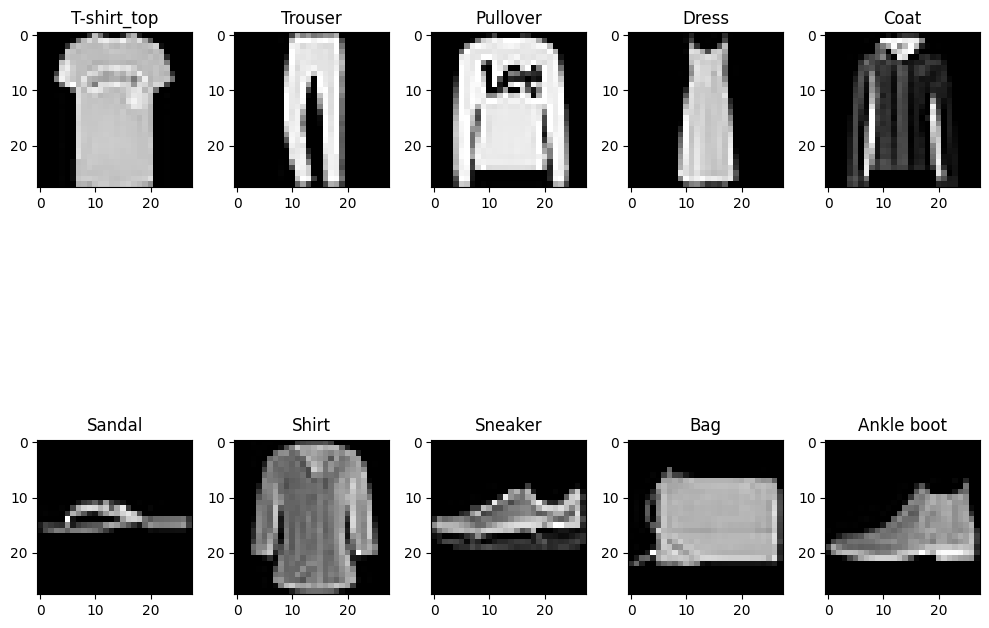

In [5]:
unique_classes = np.unique(y_test)

plt.figure(figsize=(10, 10))

for i, cls in enumerate(unique_classes):
    idx = np.where(y_test == cls)[0][0]  # Pobiera indeks pierwszego wystąpienia klasy
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx], cmap='gray', interpolation='none')
    plt.title("{}".format(class_names[y_test[idx]]))
plt.tight_layout()
plt.show()

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1. 

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [6]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
10


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [7]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [8]:
model = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 64)                247872    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [10]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4389 - accuracy: 0.8448 - val_loss: 0.3282 - val_accuracy: 0.8811
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2904 - accuracy: 0.8953 - val_loss: 0.2888 - val_accuracy: 0.8940
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2433 - accuracy: 0.9117 - val_loss: 0.2637 - val_accuracy: 0.9045
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2109 - accuracy: 0.9216 - val_loss: 0.2392 - val_accuracy: 0.9135
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1829 - accuracy: 0.9319 - val_loss: 0.2418 - val_accuracy: 0.9146
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1590 - accuracy: 0.9411 - val_loss: 0.2500 - val_accuracy: 0.9106
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1391 - accuracy: 0.9488 - val_loss: 0.2459 - val_ac

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [11]:
export_dir = 'saved_model'

In [12]:
model.save(export_dir)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [13]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  tflite_model = converter.convert()

  with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". 

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [14]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  
  #TODO ustaw odpowiedni rodzaj optymalizacji sieci neuronowej

  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_model = converter.convert()

  with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [15]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)

def test_model_accuracy(tflite_model):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    correct_predictions = 0
    total_samples = len(X_test)
    total_latency = 0
    
    for img, label in zip(X_test, y_test):
        # mierzymy czas rozpoczęcia i zakończenia wykonywania predykcji
        start_time = time.time()
    
        interpreter.set_tensor(input_index, [img])
        interpreter.invoke()
        prediction = interpreter.get_tensor(output_index)
        label_is = np.argmax(prediction, axis=-1)[0]
        label_should_be = label
    
        end_time = time.time()
        total_latency += end_time - start_time
    
        if label_is == label_should_be:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_samples
    latency = total_latency / total_samples
    
    return accuracy, latency


In [16]:
#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-base.tflite"))
accuracy_base, latency_base = test_model_accuracy("model-base.tflite")

#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-quant.tflite"))
accuracy_quant, latency_quant = test_model_accuracy("model-quant.tflite")

(0.92, 5.480432510375977e-05)
(0.9201, 0.003357930517196655)


In [17]:
import os
def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)  # Przekształcenie bajtów na megabajty

In [18]:
base_model_size = get_file_size("model-base.tflite")
quant_model_size = get_file_size("model-quant.tflite")

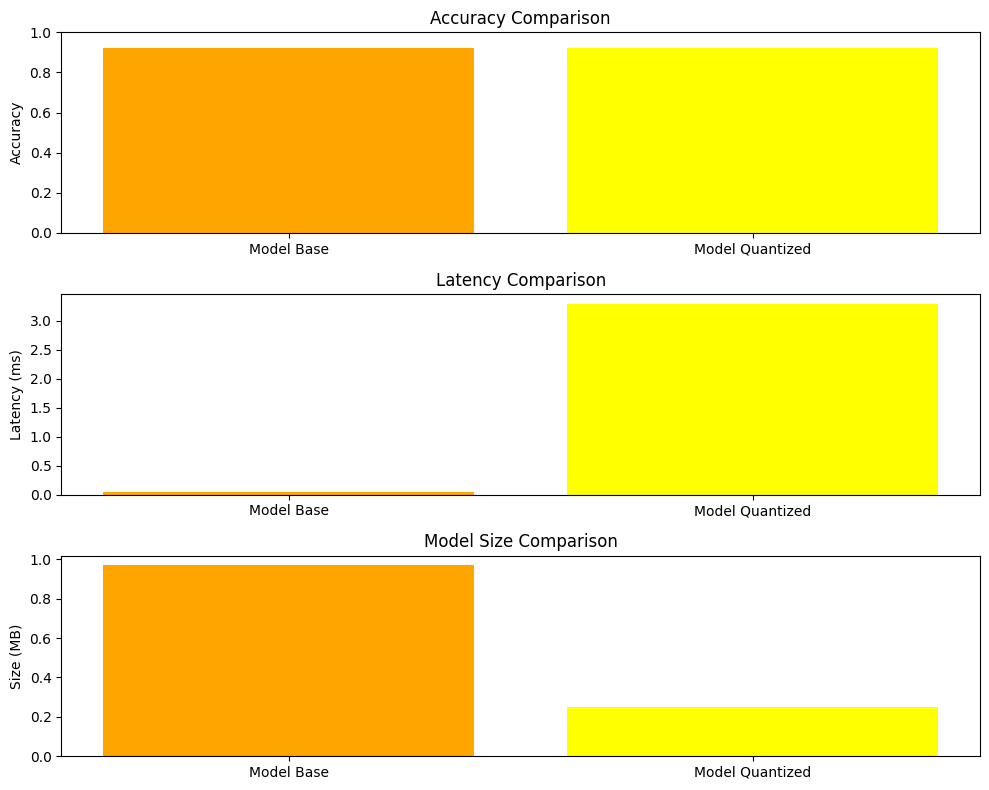

In [19]:
# porównaj dokladnosc wynikowych modeli TFLite
categories = ['Model Base', 'Model Quantized']
accuracies = [accuracy_base, accuracy_quant]
# Konwersja sekund na milisekundy
latencies = [latency_base * 1e3, latency_quant * 1e3]
sizes = [base_model_size, quant_model_size]

# Wykres słupkowy
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Dokładność
ax[0].bar(categories, accuracies, color=['orange', 'yellow'])
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)  # Zakres osi Y od 0 do 1

# Opuźnienie
ax[1].bar(categories, latencies, color=['orange', 'yellow'])
ax[1].set_title('Latency Comparison')
ax[1].set_ylabel('Latency (ms)')

# Rozmiar
ax[2].bar(categories, sizes, color=['orange', 'yellow'])
ax[2].set_title('Model Size Comparison')
ax[2].set_ylabel('Size (MB)')

plt.tight_layout()
plt.show()


 # Wnioski

Kwantyzacja, czyli zmniejszenie precyzji wag i/lub aktywacji, może prowadzić do straty dokładności modelu. W związku z tym, model skwantyzowany może wymagać większej liczby iteracji lub obliczeń, aby osiągnąć podobny poziom dokładności co model zwykły, co prowadzi do obserwowanej wyższej latency. 

Model TensorFlow-Lite jak oczekiwano zajmuje mniej miejsca niż pełna wersja modelu TensorFlow.